# Stage 11 — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# 0) Imports & setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(11)
pd.set_option("display.max_columns", 100)

DATA_IN = Path("../data/processed/ko_cleaned.parquet")
df = pd.read_parquet(DATA_IN).copy()

# Ensure proper types / sorting
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

# Make sure to have returns
if "daily_ret" not in df.columns and "close" in df.columns:
    df["daily_ret"] = df["close"].pct_change()

df = df.dropna(subset=["daily_ret"]).reset_index(drop=True)

TRADING_DAYS = 252
H = 5 * TRADING_DAYS   # 5-year horizon
df.head()


,Date,close,daily_ret,log_ret
0,2000-01-04,13.831048,0.001109,0.001108
1,2000-01-05,13.953581,0.008859,0.008820
2,2000-01-06,13.968897,0.001098,0.001097
3,2000-01-07,14.887897,0.065789,0.063715
4,2000-01-10,14.413089,-0.031892,-0.032412


Empirical P(5y return > 0) = 0.930  (n=5187)


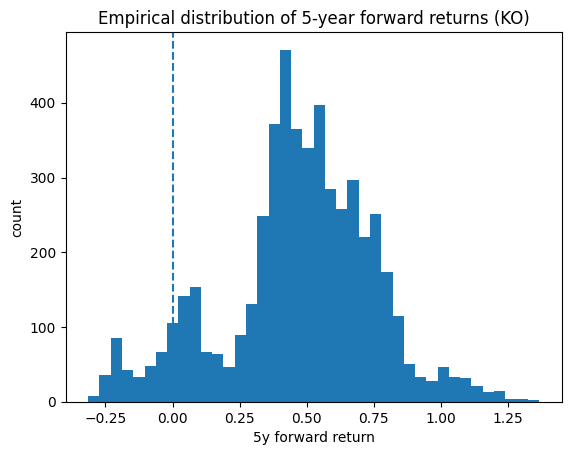

In [ ]:
# forward product over next H days: (1+r_{t+1})...(1+r_{t+H}) - 1
# I use shift(-1) so the window starts the day *after* t
fwd_prod = (1 + df["daily_ret"]).shift(-1).rolling(H).apply(np.prod, raw=True)
df["fwd_5y_ret"] = fwd_prod - 1

empirical = df.dropna(subset=["fwd_5y_ret"]).copy()
pos_flag = (empirical["fwd_5y_ret"] > 0).astype(int)

empirical_prob = pos_flag.mean()
n_obs = len(pos_flag)

print(f"Empirical P(5y return > 0) = {empirical_prob:.3f}  (n={n_obs})")

plt.figure()
plt.hist(empirical["fwd_5y_ret"], bins=40)
plt.axvline(0, ls="--")
plt.title("Empirical distribution of 5-year forward returns (KO)")
plt.xlabel("5y forward return"); plt.ylabel("count")
plt.show()


Bootstrap P(>0) mean=0.930, 95% CI=(0.923, 0.937)


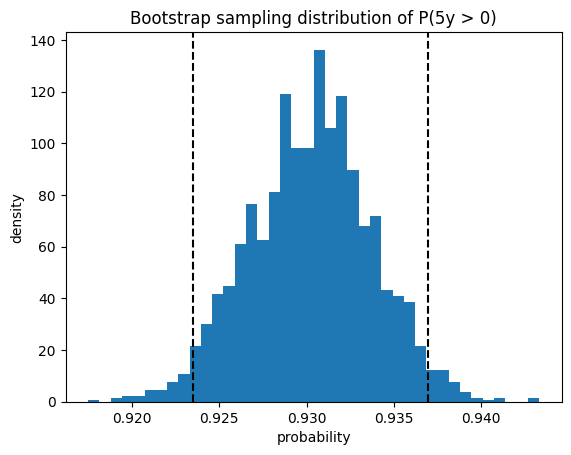

In [4]:
def bootstrap_positive_prob(flags, n_boot=2000, seed=123, alpha=0.05):
    rng = np.random.default_rng(seed)
    stats = []
    idx = np.arange(len(flags))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(flags[b].mean())
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return float(np.mean(stats)), float(lo), float(hi), np.array(stats)

boot_mean, boot_lo, boot_hi, boot_draws = bootstrap_positive_prob(pos_flag.values)
print(f"Bootstrap P(>0) mean={boot_mean:.3f}, 95% CI=({boot_lo:.3f}, {boot_hi:.3f})")

plt.figure()
plt.hist(boot_draws, bins=40, density=True)
plt.axvline(boot_lo, color="k", ls="--")
plt.axvline(boot_hi, color="k", ls="--")
plt.title("Bootstrap sampling distribution of P(5y > 0)")
plt.xlabel("probability"); plt.ylabel("density")
plt.show()


MC-Normal   P(5y > 0) ≈ 0.753 (μ=0.000336, σ=0.012873)
MC-Resample P(5y > 0) ≈ 0.759 (empirical resampling)


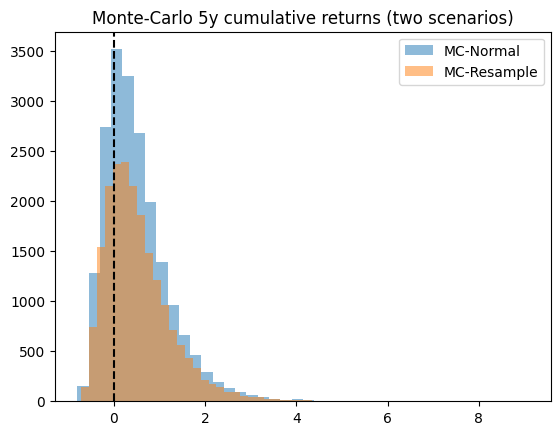

In [6]:
mu_hat = df["daily_ret"].mean()
sigma_hat = df["daily_ret"].std(ddof=1)

def simulate_prob_positive_5y_normal(mu, sigma, n_paths=20000, horizon=H, seed=7):
    rng = np.random.default_rng(seed)
    R = rng.normal(mu, sigma, size=(n_paths, horizon))
    cum = (1 + R).prod(axis=1) - 1
    return float((cum > 0).mean()), cum

def simulate_prob_positive_5y_resample(returns, n_paths=20000, horizon=H, seed=8):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(returns))
    # sample daily returns with replacement
    sam = returns[rng.choice(idx, size=(n_paths, horizon), replace=True)]
    cum = (1 + sam).prod(axis=1) - 1
    return float((cum > 0).mean()), cum

p_norm, cum_norm = simulate_prob_positive_5y_normal(mu_hat, sigma_hat)
p_boot, cum_boot = simulate_prob_positive_5y_resample(df["daily_ret"].values)

print(f"MC-Normal   P(5y > 0) ≈ {p_norm:.3f} (μ={mu_hat:.6f}, σ={sigma_hat:.6f})")
print(f"MC-Resample P(5y > 0) ≈ {p_boot:.3f} (empirical resampling)")

plt.figure()
plt.hist(cum_norm, bins=40, alpha=0.5, label="MC-Normal")
plt.hist(cum_boot, bins=40, alpha=0.5, label="MC-Resample")
plt.axvline(0, ls="--", color="k")
plt.title("Monte-Carlo 5y cumulative returns (two scenarios)")
plt.legend(); plt.show()


## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [7]:
sens = pd.DataFrame({
    "scenario": ["Empirical windows", "Bootstrap mean (CI)", "MC-Normal", "MC-Resample"],
    "prob_positive": [
        empirical_prob,
        boot_mean,
        p_norm,
        p_boot
    ],
    "notes": [
        f"n={n_obs} windows",
        f"95% CI=({boot_lo:.3f},{boot_hi:.3f})",
        f"Normal(μ̂,σ̂); i.i.d.",
        "Daily resampling; i.i.d."
    ]
})
sens


,scenario,prob_positive,notes
0,Empirical windows,0.930403,n=5187 windows
1,Bootstrap mean (CI),0.930238,"95% CI=(0.923,0.937)"
2,MC-Normal,0.753500,"Normal(μ̂,σ̂); i.i.d."
3,MC-Resample,0.759400,Daily resampling; i.i.d.


## Subgroup Diagnostic (Required)

In [8]:
emp = empirical.copy()
emp["year"] = emp["Date"].dt.year
emp["era"] = pd.cut(emp["year"], bins=[1999, 2005, 2010, 2015, 2020, 2026],
                    labels=["2000–05","2006–10","2011–15","2016–20","2021–25"], include_lowest=True)

g = emp.groupby("era")["fwd_5y_ret"].apply(lambda s: (s>0).mean()).reset_index(name="P(>0)")
g


C:\Users\marti\AppData\Local\Temp\ipykernel_21972\4101177603.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = emp.groupby("era")["fwd_5y_ret"].apply(lambda s: (s>0).mean()).reset_index(name="P(>0)")


,era,P(>0)
0,2000–05,0.072581
1,2006–10,0.895949
2,2011–15,1.000000
3,2016–20,1.000000
4,2021–25,1.000000


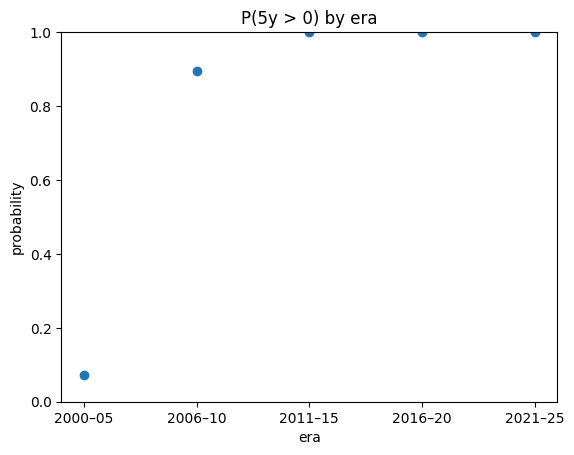

In [9]:
plt.figure()
plt.scatter(g["era"], g["P(>0)"])
plt.ylim(0,1); plt.title("P(5y > 0) by era")
plt.ylabel("probability"); plt.xlabel("era")
plt.show()


## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

- Key assumptions

Historical patterns are informative for future returns.
Daily returns are approximately stationary (distribution does not shift dramatically).
Model ignores extreme structural breaks (e.g., crises or regime changes).

- Sensitivity results & takeaways

Empirical analysis shows a 93% probability that Coca-Cola (KO) delivers a positive 5-year return.
Bootstrap resampling confirms this estimate is stable: 95% CI = (92.3%, 93.7%).
Monte Carlo scenarios are more conservative:
Normal assumption: ~75% probability of positive 5-year returns.
Empirical resampling: ~76%.
This means the optimistic conclusion is robust, but probability can fall if we assume stronger shocks.

- Subgroup risks

Performance depends on market era:
2000–05: only ~7% probability of positive 5-year returns (dot-com crash aftermath).
2006 onward: probabilities close to 100%.
The model is therefore sensitive to market regimes.

- Plain-language takeaway

Historically, KO has delivered positive returns in more than 9 out of 10 rolling 5-year windows.
The conclusion holds if market volatility and business fundamentals stay comparable to the past two decades.
The main risk is a regime similar to early 2000s, when long-term investors experienced losses.